In [264]:
## Summarize deconvolution results

import os
from glob import glob
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt 
import json

basedir = '/Users/poldrack/data_unsynced/uh2/BIDS_data/derivatives/deconvolution'
figure_dir = os.path.join(basedir, 'figures')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)
resultfiles = glob(os.path.join(basedir, 'sub*/func/*_deconvolved.tsv'))
templateflow_home  = os.environ['TEMPLATEFLOW_HOME']


# set the intended values to match on here
spec_dict = {'use_ridge': False,
            'atlas': 'Schaefer2018',
            'use_confounds': True,
            'desc': '400Parcels17Networks',
            }

def spec_dict_to_string(spec_dict):
    spec_string = []
    for k in spec_dict:
        spec_string.append('%s-%s' % (k, spec_dict[k]))
    return('_'.join(spec_string))


spec_string = spec_dict_to_string(spec_dict)



In [265]:
def get_deconv_file_info_from_json(filename):
    with open(filename.replace('.tsv', '.json')) as f:
        info_dict = json.load(f)
    info_dict ['filename'] = filename
    full_split = info_dict['filename'].split('/')
    info_dict['basedir'] = '/'.join(full_split[:-6])
    info_dict['deriv_base'] = '/'.join(full_split[:-5])
    info_dict['desc'] = info_dict['atlas_desc']
    return(info_dict)


def check_spec_match(info_dict, spec_dict):
    spec_match = True
    for key in spec_dict:
        if info_dict[key] != spec_dict[key]:
            #print('mismatch:', info_dict[key], spec_dict[key])
            spec_match = False
    return(spec_match)


datafiles = collections.defaultdict(lambda :[])
info_dict = {}
for filename in resultfiles:
    idict = get_deconv_file_info_from_json(filename)
    if check_spec_match(idict, spec_dict):
        info_dict[filename] = idict
        datafiles[info_dict[filename]['task']].append(filename)
    
    

In [275]:
def simplify_deconv_data(df):
    # the data from nideconv have multiple rows with identical values
    # which we drop to save time later on
    data_df = df.copy()
    # since time varies, we need to set it to the index so it won't be counted
    data_df.index = data_df.time
    del data_df['time']
    data_df = data_df.drop_duplicates()
    return(data_df)

def get_atlas_info(spec_dict, templateflow_home):
    atlas_info_file = os.path.join(
        templateflow_home,
        f'tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_atlas-{spec_dict["atlas"]}_desc-{spec_dict["desc"]}_dseg.tsv')
    atlas_info = pd.read_csv(atlas_info_file, sep='\t')
    atlas_info['network'] = [i.split('_')[2] for i in atlas_info.name]
    return(atlas_info)

def summarize_by_yeo_network(df, spec_dict):
    status_vars = ('event type', 'covariate', 'time', 'subcode')
    data_df = df.copy()
    for v in status_vars:
        if v in data_df:
            del data_df[v]

    atlas_info = get_atlas_info()
    
    networks = atlas_info.network.unique()
    networks_df = pd.DataFrame(index = data_df.index)
    for network in networks:
        network_idx = atlas_info.network == network
        networks_df.loc[:, network] = np.mean(data_df.values[:, network_idx], 1)
    networks_df.columns = networks
    for v in status_vars:
        if v in df.columns and v != 'covariate':
            networks_df.loc[:, v.replace(' ', '_')] = df.loc[:, v]
    return(networks_df)

In [269]:
def smooth_timeseries(df, smoothing_window = 5):
    status_vars = ('time', 'event_type')
    data_df = df.copy()
    smoothed_data = None
    
    # smooth separately for each event type since they
    # are concatenated in the dataset
    for event_type in data_df.event_type.unique():
        event_data = data_df.query('event_type == "%s"' % event_type)
        for c in event_data.columns:
            if c in status_vars:
                continue
            event_data.loc[:, c] = event_data.loc[:, c].rolling(smoothing_window).mean()
            if smoothed_data is None:
                smoothed_data = event_data
            else:
                smoothed_data = pd.concat((smoothed_data, event_data))

    return(smoothed_data)

In [270]:
combined_data = None

def get_combined_data(datafiles, spec_dict):
    for task in datafiles:
        print(f'found {len(datafiles[task])} datasets for task {task}')
        for datafile in datafiles[task]:
            data = pd.read_csv(datafile, sep='\t')
            data_simple = simplify_deconv_data(data)
            yeo_data = summarize_by_yeo_network(data_simple, spec_dict)
            yeo_data_smooth = smooth_timeseries(yeo_data)
            yeo_data_smooth['subcode'] = info_dict[datafile]['sub']
            yeo_data_smooth['task'] = task
            yeo_data_smooth['time'] = yeo_data.index
            if combined_data is None:
                combined_data = yeo_data_smooth
            else:
                combined_data = pd.concat((combined_data, yeo_data_smooth))

    combined_data_long = pd.melt(combined_data,
                                 id_vars=['event_type', 'subcode', 'task', 'time'],
                                 var_name='network', value_name='response')
    return(combined_data_long)

combined_data_long = get_combined_data(datafiles, spec_dict)

found 44 datasets for task CCTHot
found 44 datasets for task ANT
found 43 datasets for task DPX


/Users/poldrack/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


found 44 datasets for task twoByTwo
found 41 datasets for task discountFix
found 45 datasets for task WATT3
found 45 datasets for task stopSignal
found 44 datasets for task stroop
found 13 datasets for task motorSelectiveStop


plotting CCTHot
plotting ANT
plotting DPX
plotting twoByTwo
plotting discountFix
plotting WATT3
plotting stopSignal
plotting stroop
plotting motorSelectiveStop


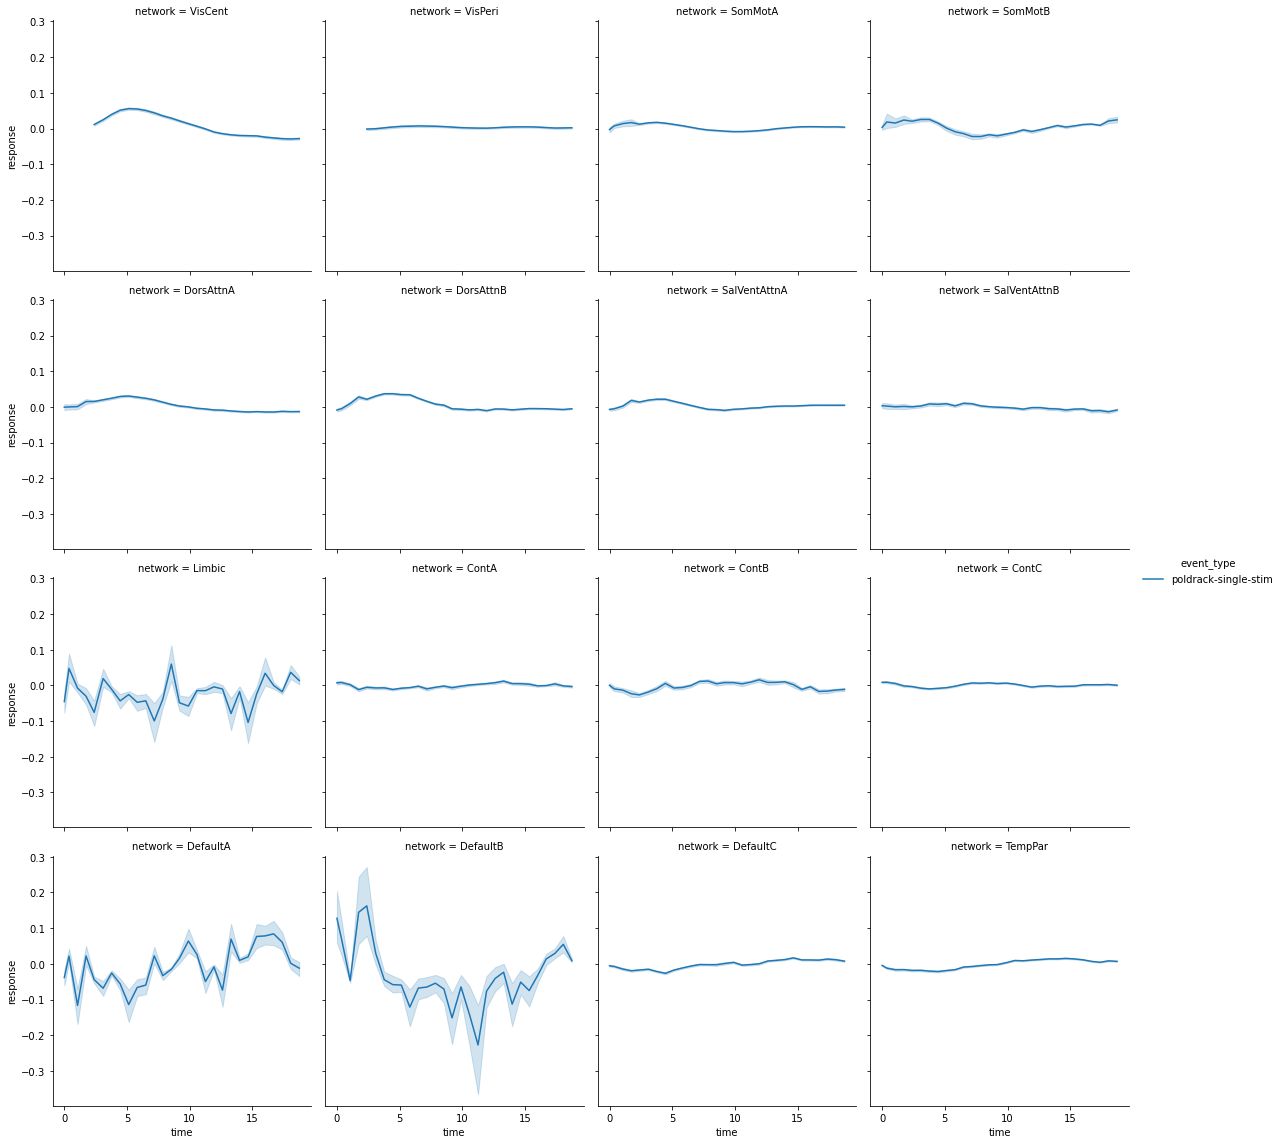

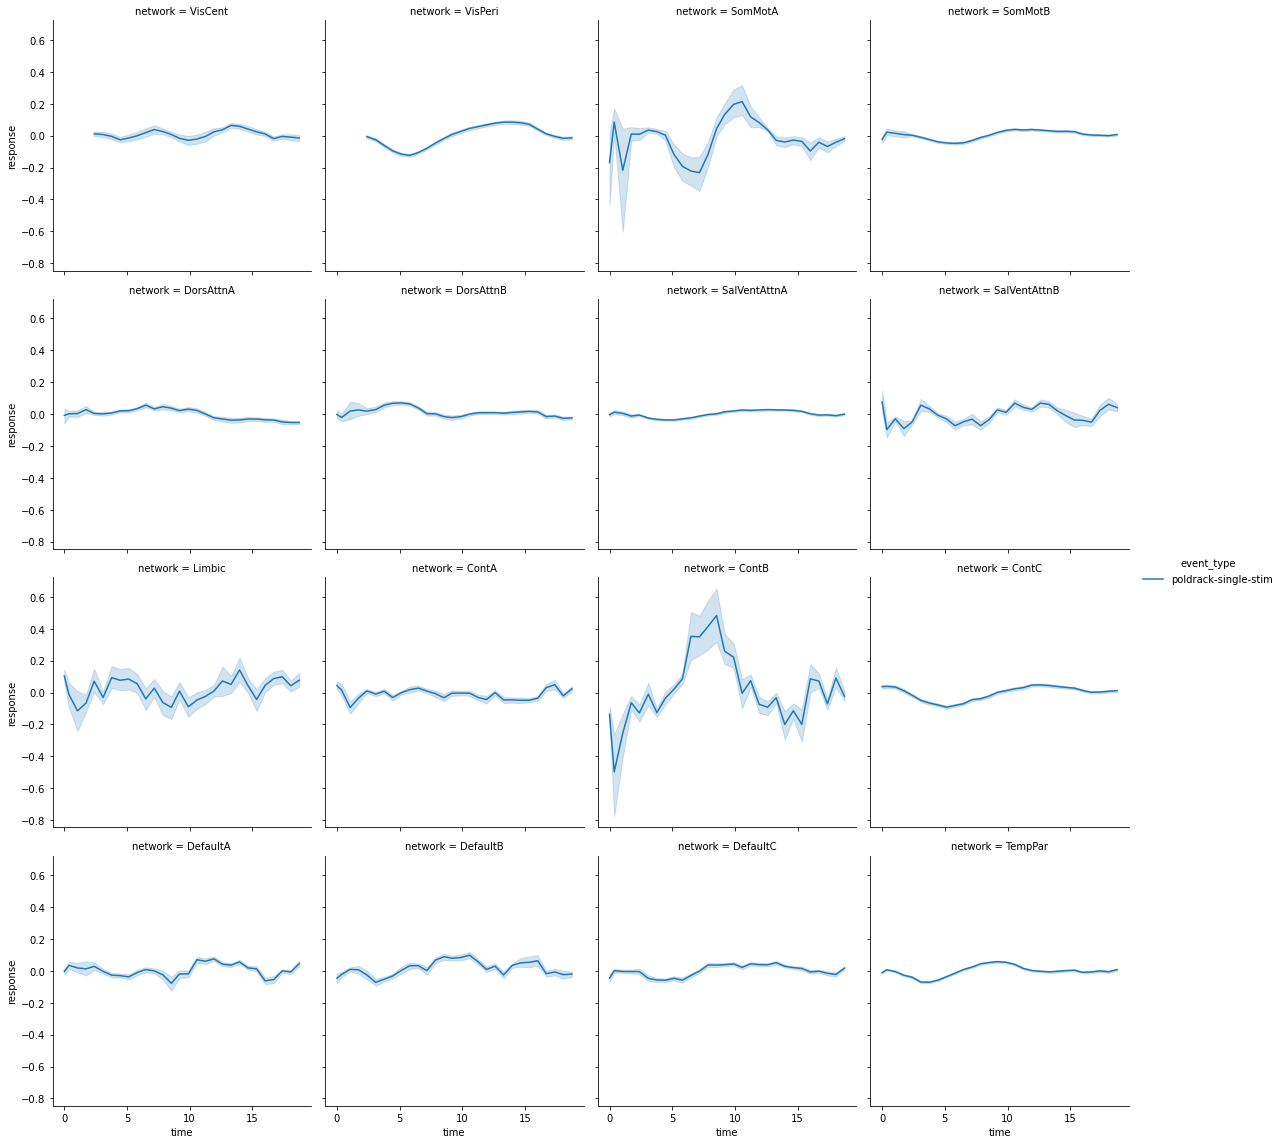

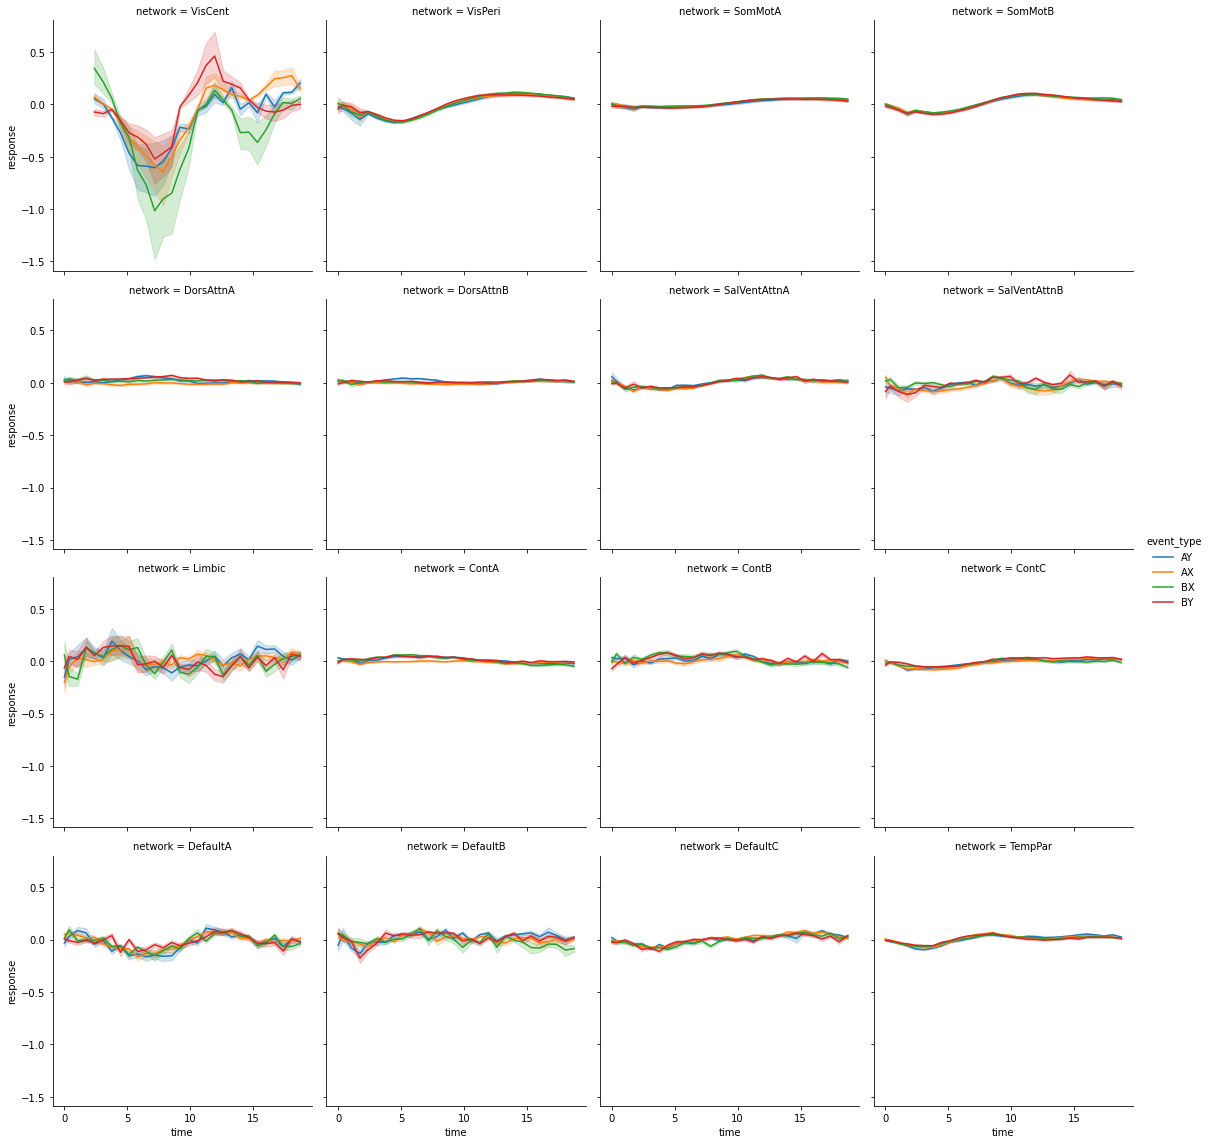

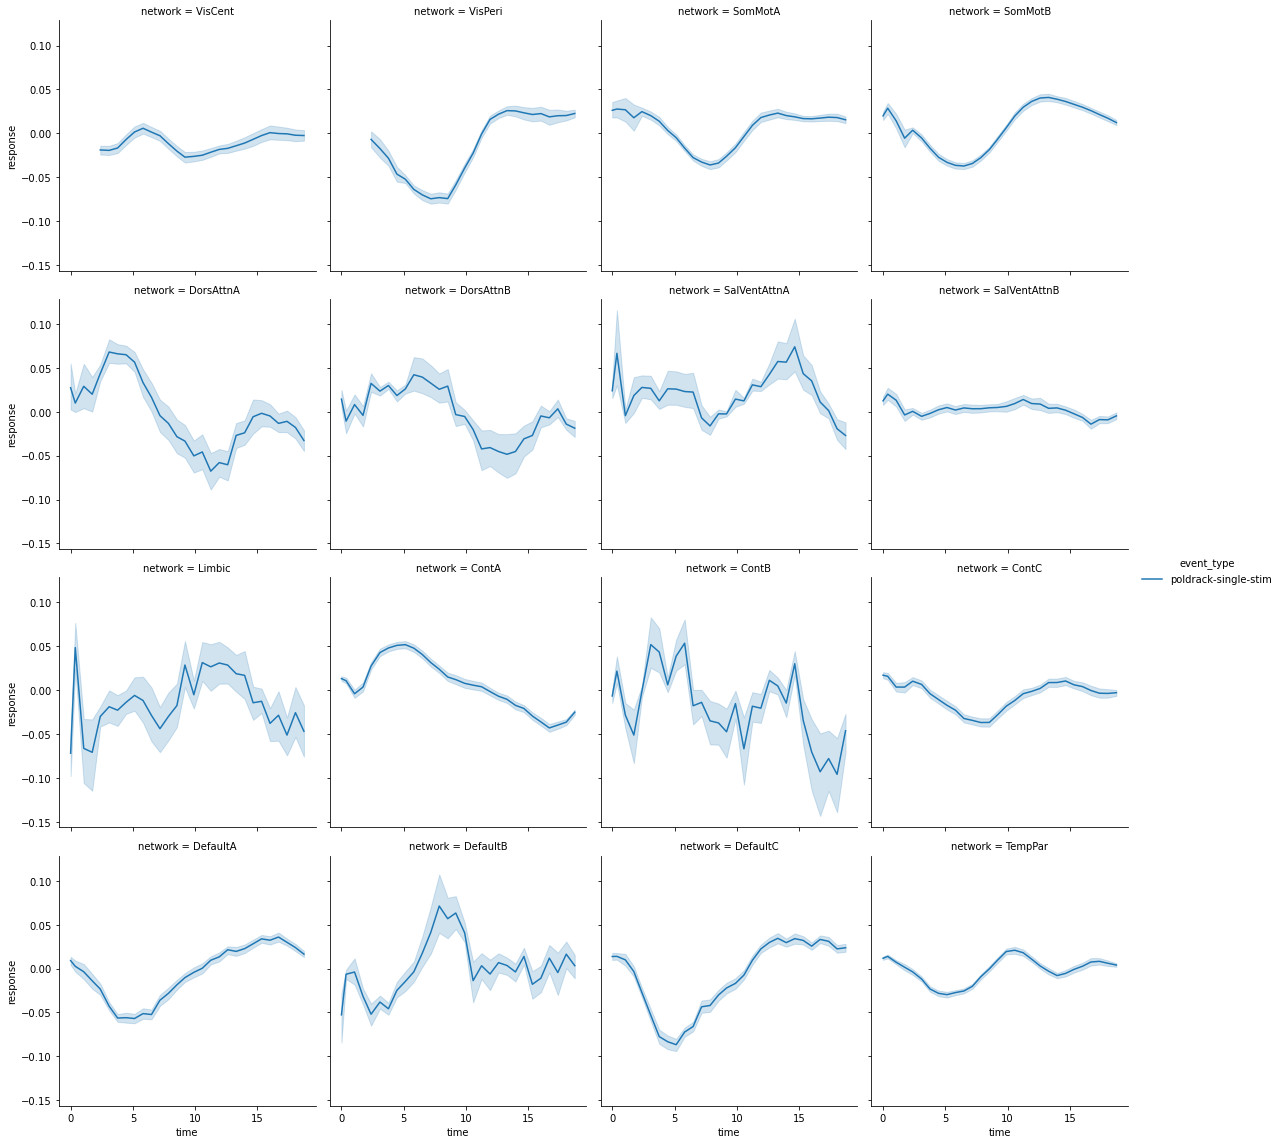

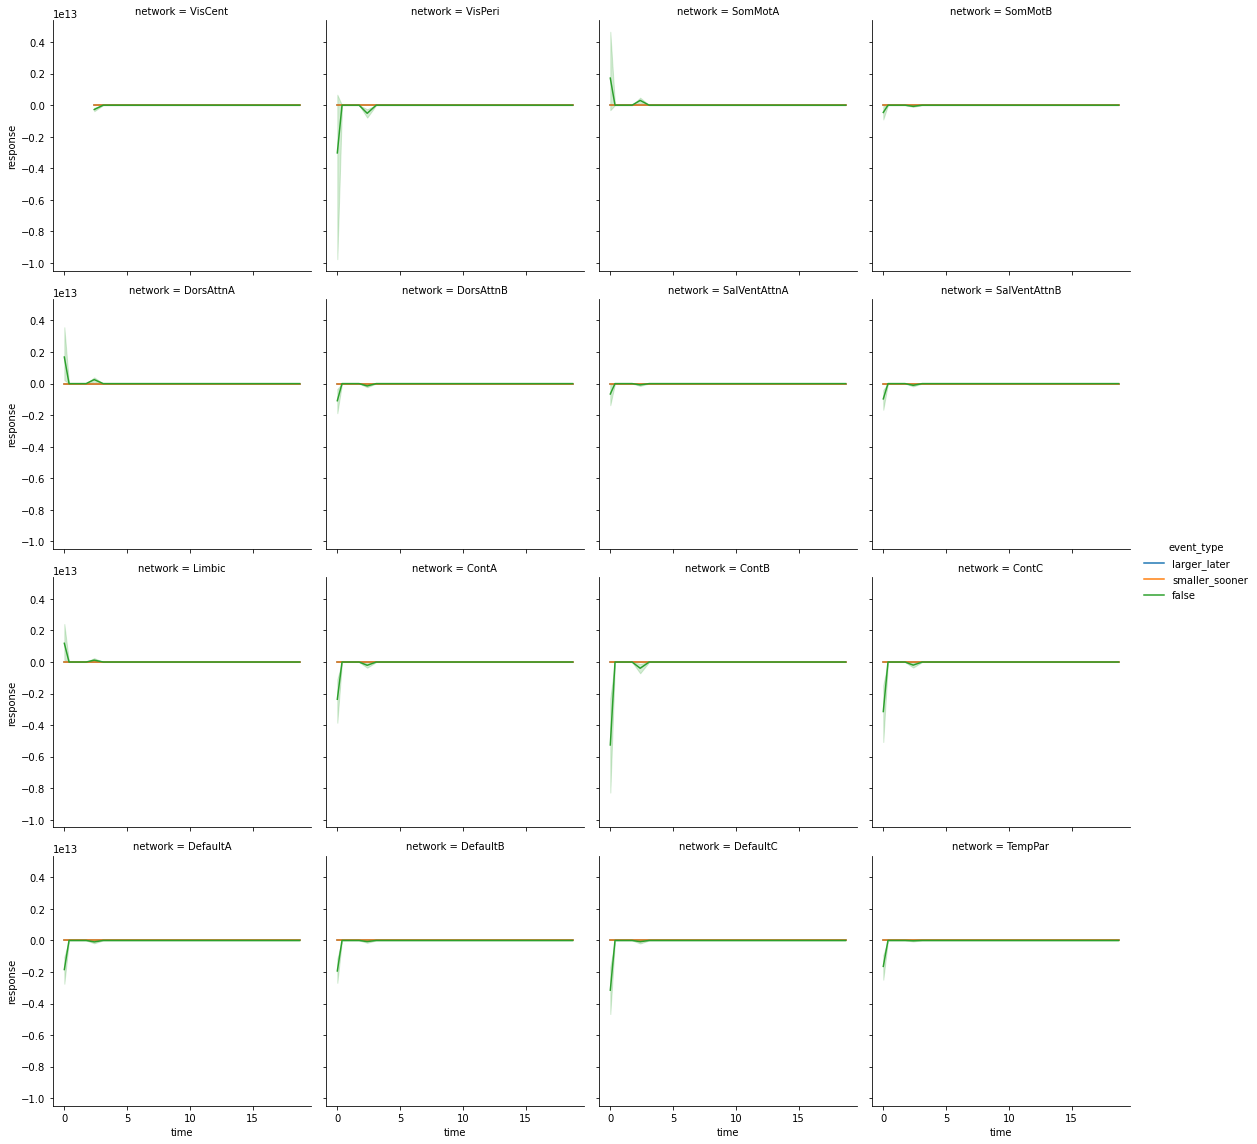

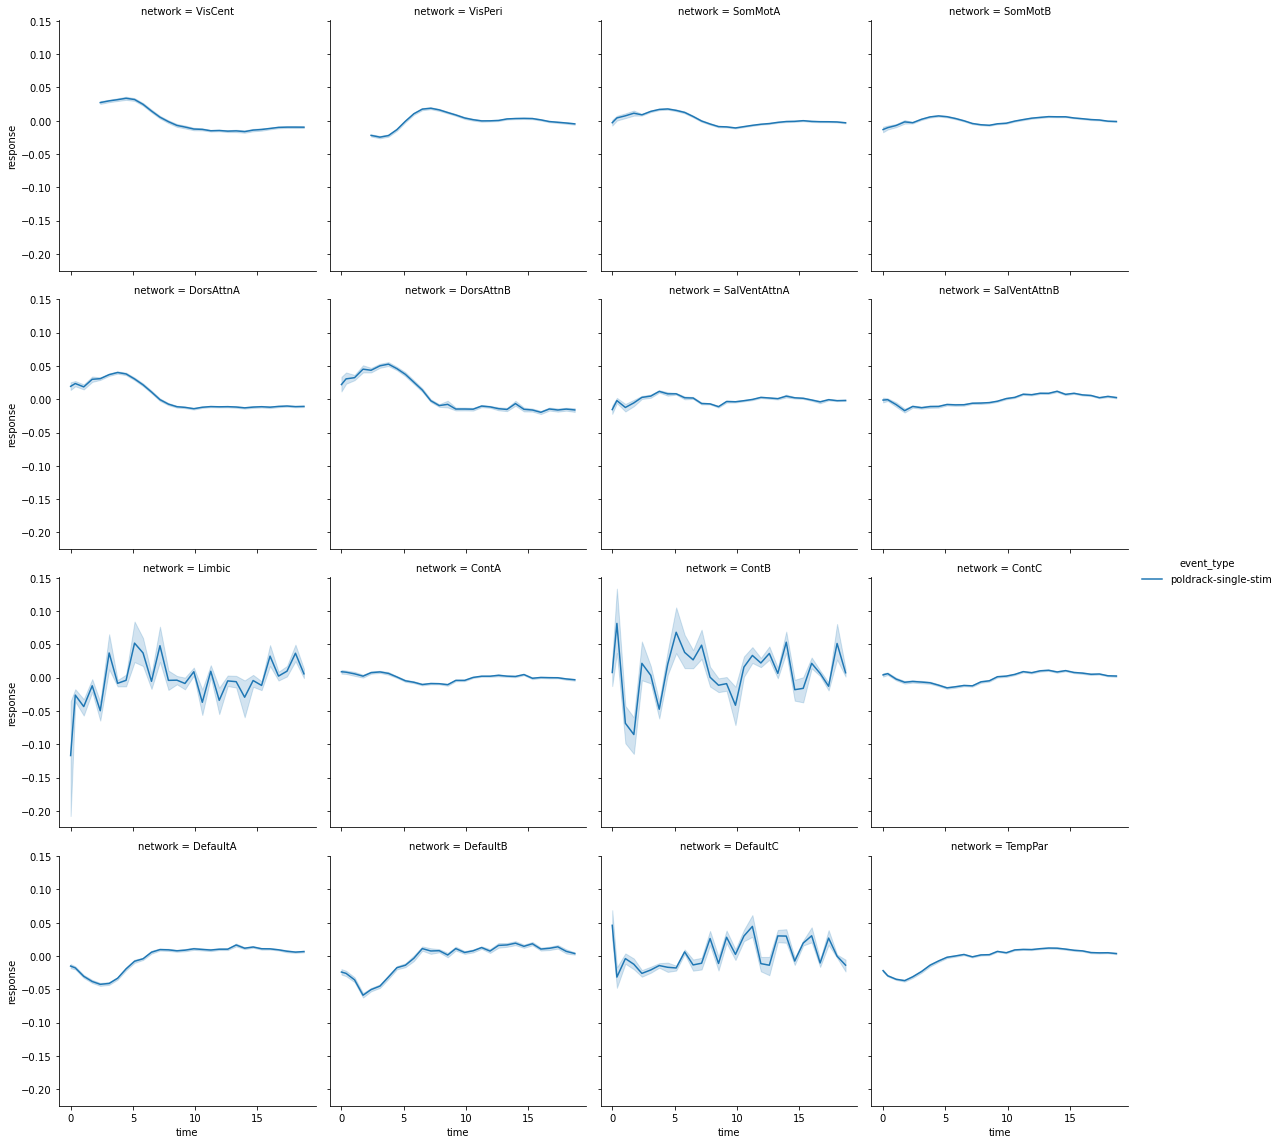

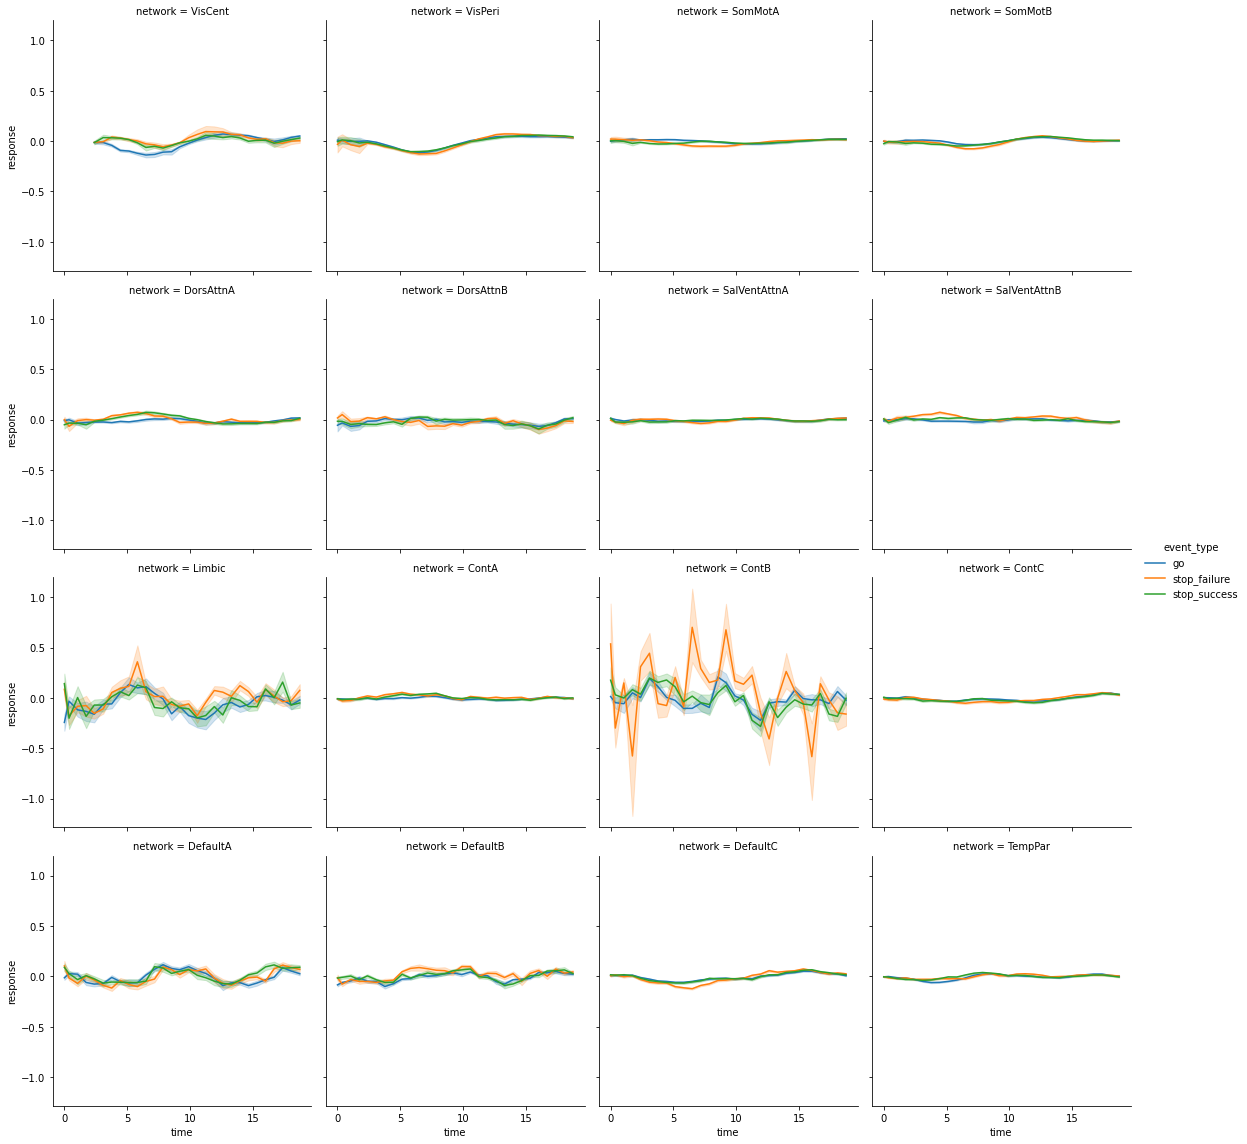

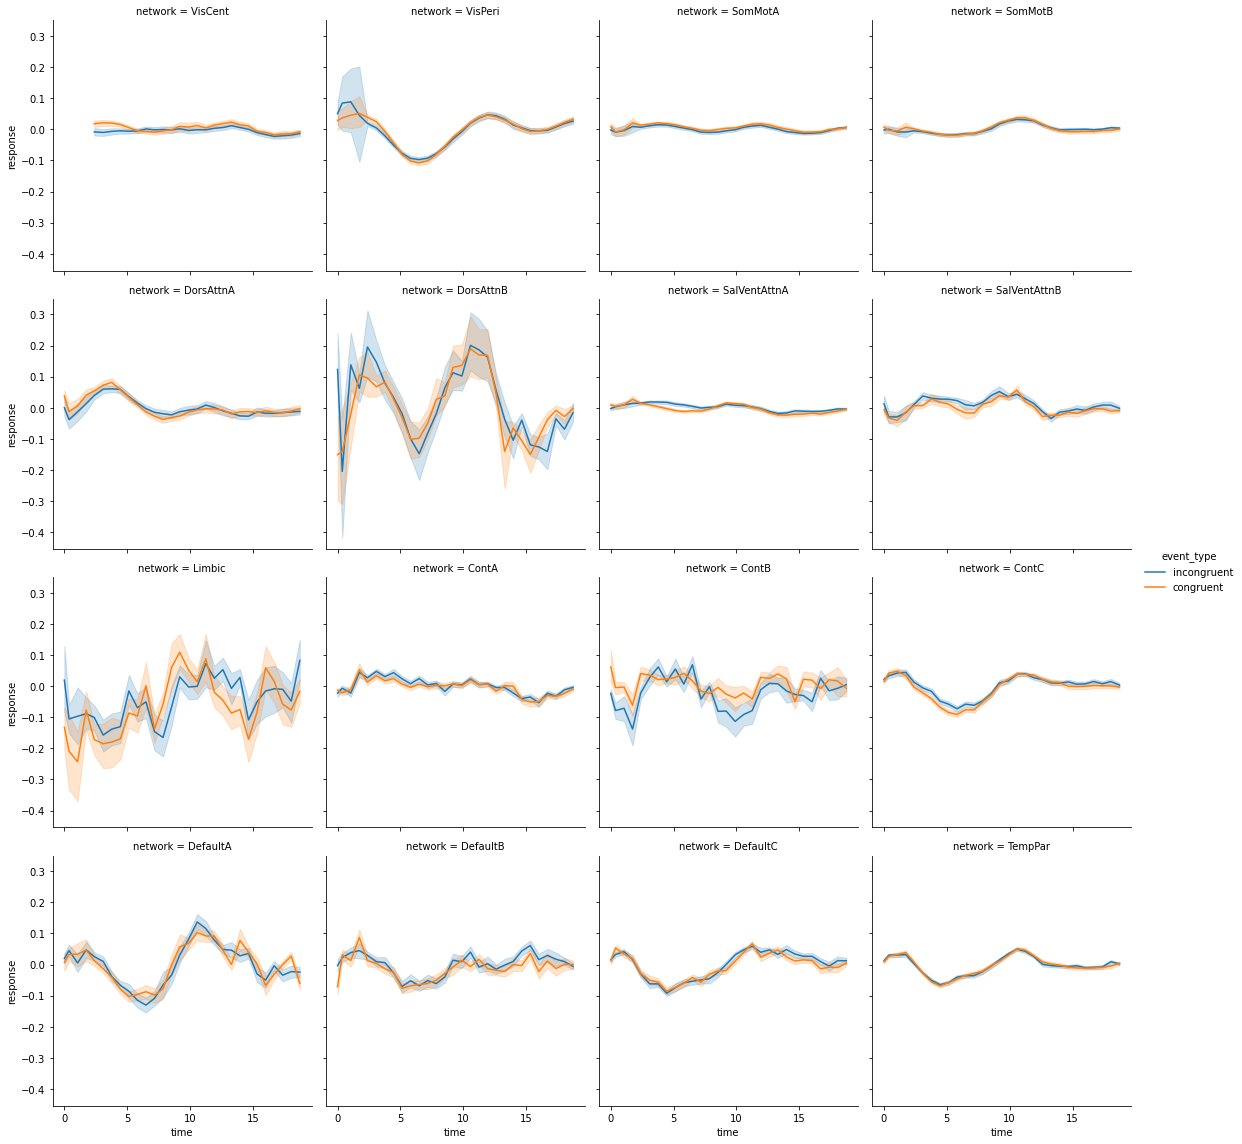

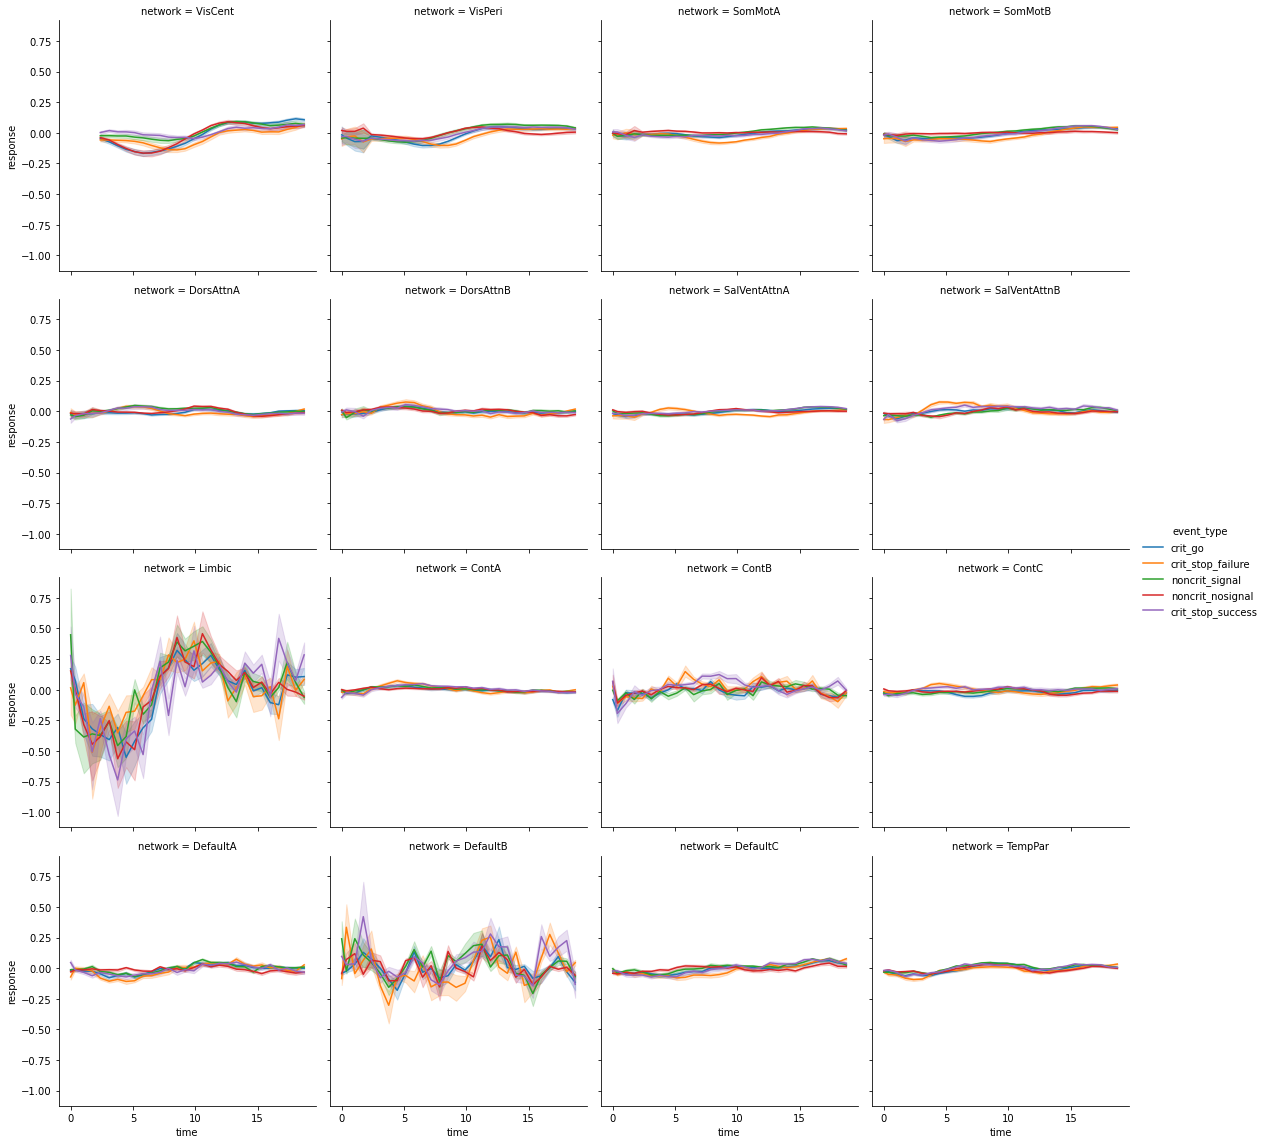

In [273]:
def make_network_plots(combined_data, task, spec_string, figure_dir):
    df = combined_data_long.query('task == "%s"' % task)
    g = sns.FacetGrid(df, col="network", col_wrap=4, height=4, hue='event_type')
    g.map(sns.lineplot, 'time', 'response')
    g.add_legend()
    g.fig.suptitle(task, fontsize=16)
    plt.savefig(os.path.join(figure_dir, '%s_%s_deconv.pdf' % (task, spec_string)))
    
for task in combined_data.task.unique():
    print('plotting', task)
    make_network_plots(combined_data, task, spec_string, figure_dir)
  